In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import itertools
import joblib
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score

In [21]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()
df.describe()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04,91379.000000,91379.000000,91379.000000,...,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,11.619098,9.553919,10.032760,9.076251,3297.930328,7.850005e+10,27.065979,28.417120,25.717089,...,13.166020,11.904558,11.373193,32986.417484,34636.684647,31331.618978,89.043304,0.739065,1.851020,0.702242
std,3.903843,3.438873,5.858577,6.162798,5.575927,1224.305893,5.000027e+09,72.134023,75.761896,68.595239,...,9.589755,8.694028,6.942229,24713.874445,25978.845228,23497.873065,26.415610,0.871314,1.762698,0.828796
min,0.788363,0.027142,1.141556,1.238270,1.049744,2012.000148,7.350000e+10,0.000000,0.000000,0.000000,...,-6.693373,-7.270075,0.000000,10.151990,11.029667,9.484346,0.000000,0.000000,0.000000,0.000000
25%,3.473063,10.829331,4.958993,5.205861,4.709511,2019.431812,7.350000e+10,0.000000,0.000000,0.000000,...,4.905387,4.438425,5.000000,11158.598400,11721.447545,10588.793240,82.976727,0.076749,0.512667,0.072912
50%,6.336167,11.856560,6.870737,7.205499,6.524046,2959.863686,8.350000e+10,0.000000,0.000000,0.000000,...,10.803943,9.774467,11.000000,26378.636210,27686.214030,25047.188460,90.867362,0.437995,1.323101,0.416274
75%,8.664984,12.847944,14.049470,14.782679,13.379256,4820.890157,8.350000e+10,16.947618,17.775980,16.038090,...,22.470382,20.322434,17.000000,53493.821285,56092.212375,50797.690405,98.482652,1.088621,2.681788,1.036574
max,32.455222,46.893150,24.790883,26.407305,24.268431,4827.999971,8.350000e+10,1621.001906,1753.747866,1500.666382,...,40.771383,36.724191,23.000000,75004.999150,82503.130080,74999.343410,360.000000,7.799086,16.421115,7.252319


In [22]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

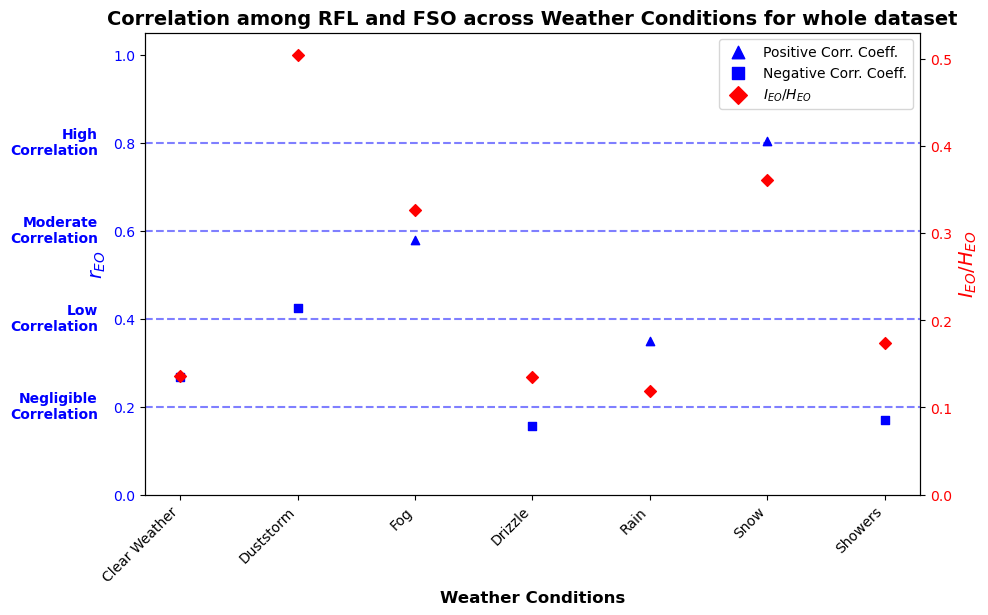

In [23]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = df[df['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_Att']
    fso_pred = subset['FSO_Att']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.8, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.6, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.4, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.2, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for whole dataset', fontsize=14, fontweight='bold')


plt.show()


In [24]:
#read csv
result = pd.read_csv("ProjectB_results.csv")
result.head()
result.describe()

,Unnamed: 0,SYNOPCode,y_pred_FSO_2,y_pred_RFL_2,FSO_pred_1,RFL_pred_1,y_FSO_test,y_RFL_test
count,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000
mean,45791.923233,2.213121,6.784340,11.627155,6.790268,11.633345,6.811413,11.645939
std,26350.544074,2.879741,3.743087,3.386108,3.755326,3.390633,3.965527,3.507115
min,0.000000,0.000000,0.947989,2.557802,0.975672,2.626739,0.848391,0.786776
25%,22963.000000,0.000000,3.502884,10.941934,3.525891,10.937469,3.457215,10.841029
50%,45576.000000,0.000000,6.493791,11.796581,6.490396,11.793823,6.371891,11.858661
75%,68574.500000,6.000000,8.645874,12.784720,8.670562,12.789663,8.676777,12.868948
max,91376.000000,8.000000,29.914377,45.519103,29.828592,46.124628,31.966746,46.853960


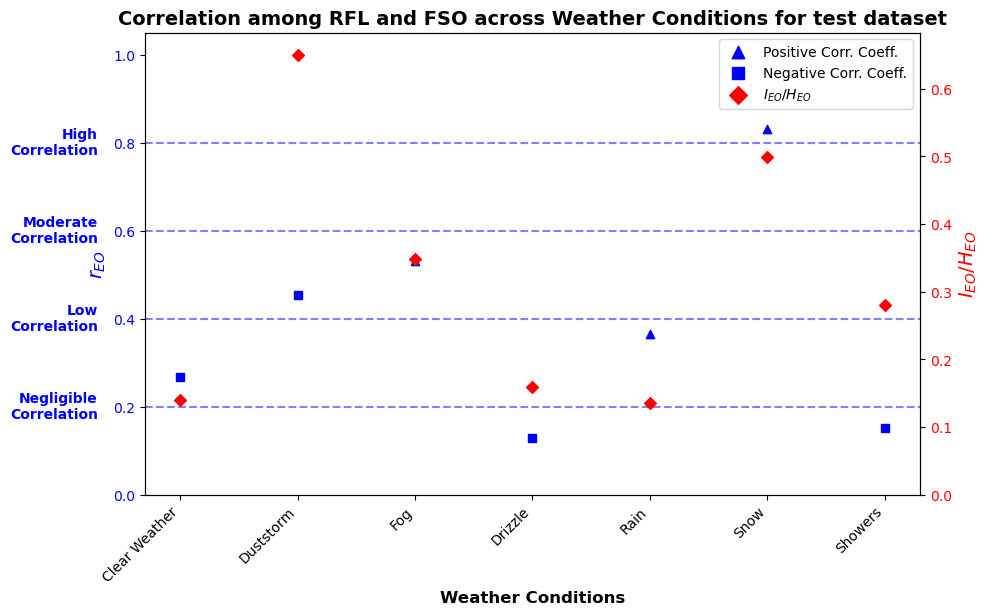

In [25]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['y_RFL_test']
    fso_pred = subset['y_FSO_test']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.8, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.6, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.4, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.2, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for test dataset', fontsize=14, fontweight='bold')


plt.show()

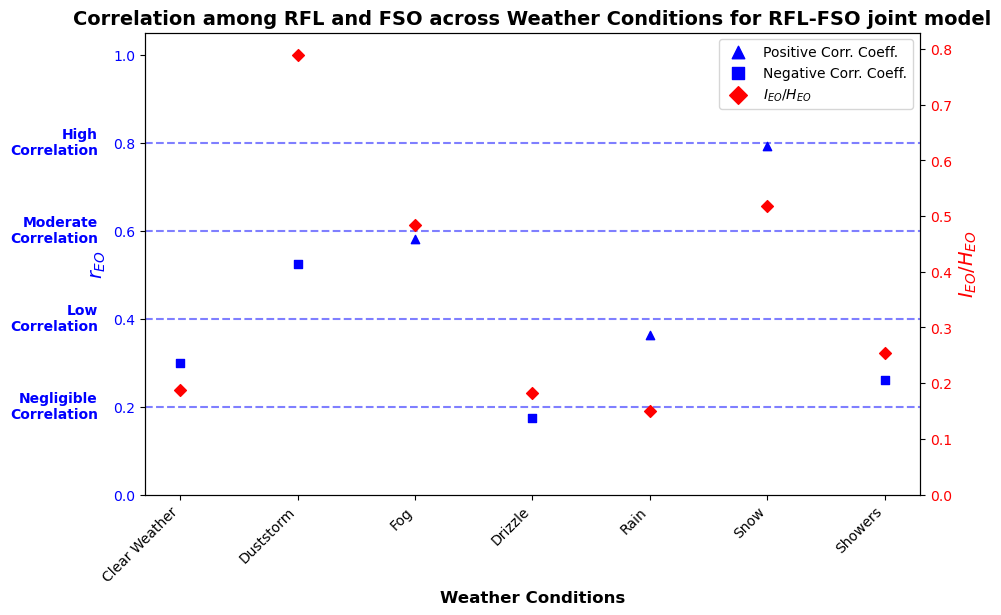

In [26]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_pred_1']
    fso_pred = subset['y_pred_FSO_2']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.8, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.6, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.4, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.2, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for RFL-FSO joint model', fontsize=14, fontweight='bold')


plt.show()

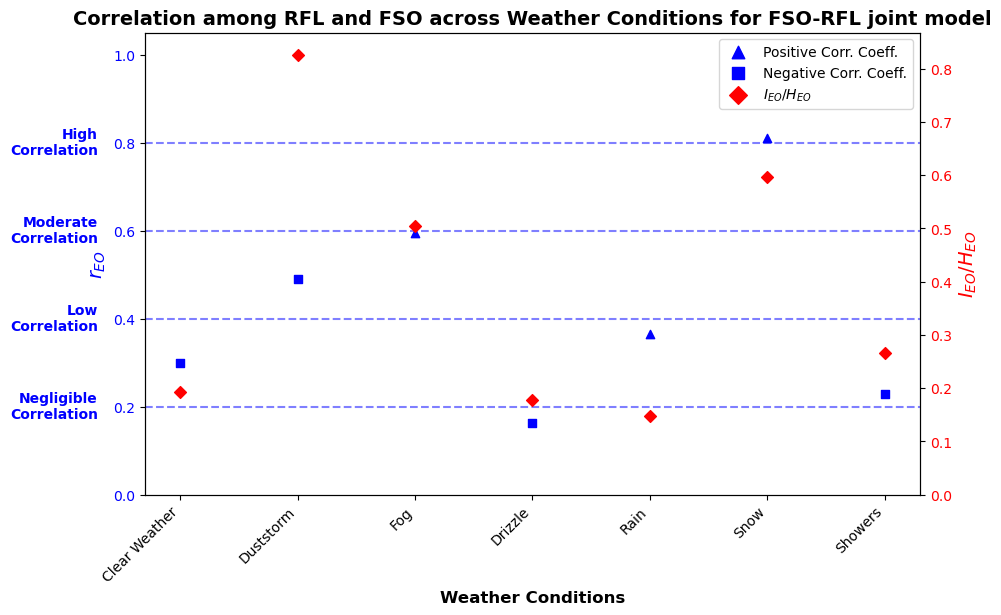

In [27]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['y_pred_RFL_2']
    fso_pred = subset['FSO_pred_1']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.8, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.6, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.4, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.2, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for FSO-RFL joint model', fontsize=14, fontweight='bold')


plt.show()

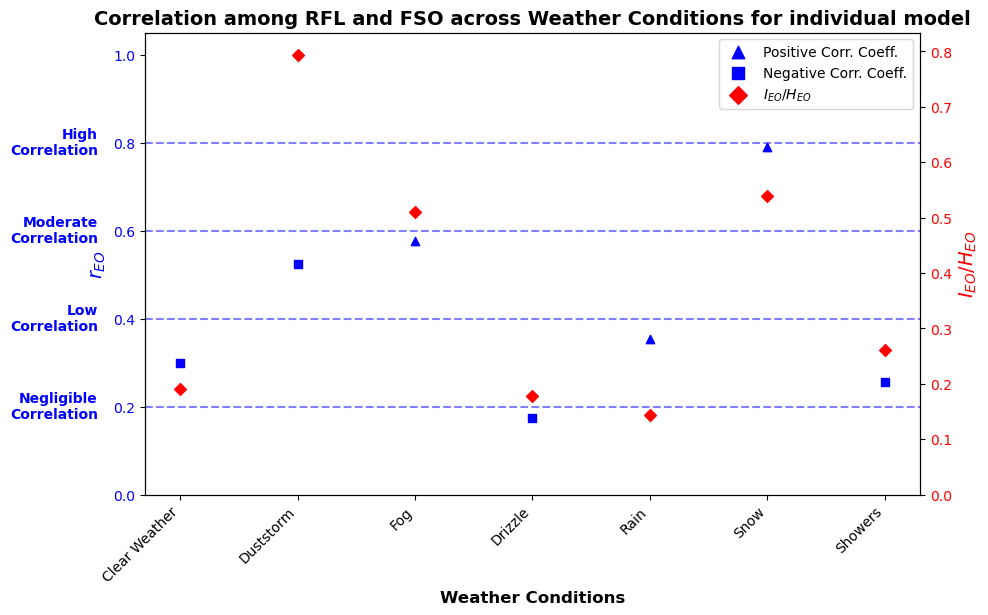

In [28]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_pred_1']
    fso_pred = subset['FSO_pred_1']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.8, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.6, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.4, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.2, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for individual model', fontsize=14, fontweight='bold')


plt.show()